# Análise sobre cidades

### Bibliotecas necessárias


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime

### Passando a base de dados para Pandas

In [2]:
conn = sqlite3.connect('../db.sqlite3')
cur = conn.cursor()

query = '''
SELECT * 
FROM delphone_empresa
'''

empresa = pd.read_sql(query, con = conn)

empresa = empresa.drop(columns = 'id') 

empresa.head()

,nome,email,celular,endereco,estado,cidade,setor,n_funcionario,n_filiais,data_criacao,faturamento_anual,horario_abertura,horario_fechamento
0,Vega-Davis,moniquepatterson@example.net,619-235-8267x594,"39072 Dominguez Brooks\nNew Sean, AL 24938",RS,Vila Maria,Papelaria,945.0,57.0,1983-08-15,261.0,14:22:00,07:55:39
1,"Molina, Turner and Evans",rcarpenter@example.net,793-057-3456x927,"386 James Neck\nJasminefort, WV 94271",BA,Riachão Das Neves,Esportes,380.0,86.0,2021-02-01,535.0,04:08:05,07:35:00
2,Cameron-Mcdonald,charlesanderson@example.com,001-182-115-3409,"8674 Jose Lock Apt. 550\nLake Malikview, LA 39125",MG,Itanhomi,Vestuário,540.0,34.0,2005-07-11,573.0,10:35:44,19:29:34
3,Mcdonald-Hudson,msanders@example.com,+1-924-043-5432x16295,"385 Brett Valleys\nNorth Mary, NE 72357",CE,Ipueiras,Cozinha,283.0,26.0,1997-08-31,955.0,09:02:09,01:30:08
4,Myers-Diaz,carrolldeborah@example.com,(779)083-8986,"65693 Lee Court Apt. 876\nNew Victorialand, KY...",PB,Santa Cecília,Esportes,322.0,3.0,1978-05-19,459.0,04:40:42,15:31:53


In [3]:
conn = sqlite3.connect('../db.sqlite3')
cur = conn.cursor()

query = '''
SELECT * 
FROM delphone_busca
'''

busca = pd.read_sql(query, con = conn)

busca = busca.drop(columns = 'id') 

## Preparação para perguntas de negócio

Note que as datas estão são `object`, mas queremos que ela seja `datetime64[ns]`

In [4]:
empresa.dtypes

nome                   object
email                  object
celular                object
endereco               object
estado                 object
cidade                 object
setor                  object
n_funcionario         float64
n_filiais             float64
data_criacao           object
faturamento_anual     float64
horario_abertura       object
horario_fechamento     object
dtype: object

In [5]:
empresa['horario_abertura']= pd.to_datetime(empresa['horario_abertura'], format='%H:%M:%S')
empresa['horario_fechamento']= pd.to_datetime(empresa['horario_fechamento'], format='%H:%M:%S')
empresa.dtypes

nome                          object
email                         object
celular                       object
endereco                      object
estado                        object
cidade                        object
setor                         object
n_funcionario                float64
n_filiais                    float64
data_criacao                  object
faturamento_anual            float64
horario_abertura      datetime64[ns]
horario_fechamento    datetime64[ns]
dtype: object

As perguntas de negócio se referem ao tempo que as empresas passam abertas, mas não existe essa coluna no DataFrame. Por isso, vamos criá-la, ignorando valores negaticos, pois estes não nos interessam. Note que todos devem possuir 0 dias abertos.

In [6]:
empresa['tempo_aberto']= abs(empresa['horario_abertura'] - empresa['horario_fechamento'])
empresa['tempo_aberto']

0     0 days 06:26:21
1     0 days 03:26:55
2     0 days 08:53:50
3     0 days 07:32:01
4     0 days 10:51:11
            ...      
995   0 days 06:57:29
996   0 days 14:52:00
997   0 days 02:46:57
998   0 days 17:25:11
999   0 days 02:51:13
Name: tempo_aberto, Length: 1000, dtype: timedelta64[ns]

Como as análises serão feitas por `setor` e por `estado`, vamos excluir do DataFrame as colunas que não nos interessam para a análise

In [7]:
empresa_setor = empresa[['setor', 'tempo_aberto']]
empresa_estado = empresa[['estado', 'tempo_aberto']]


## Pergunta 1: Qual a média, máximo e mínimo, por setor, do tempo que as empresas passam abertas?

### O máximo

É importante para determinar aqueles setores que passam muito tempo abertas, e, com isso, podemos estudar/conjecturar padrões de horários de ápice de consumo. 

In [8]:
max_setor = empresa_setor.groupby(['setor']).max().reset_index()
max_setor['tempo_aberto'] = max_setor['tempo_aberto'].dt.seconds
max_setor

,setor,tempo_aberto
0,Alimentação,78614
1,Cozinha,78462
2,Eletrodomésticos,78784
3,Esportes,75363
4,Farmácia,78431
5,Material de construção,78582
6,Mobília,83130
7,Música,82912
8,Papelaria,83299
9,Vestuário,82359


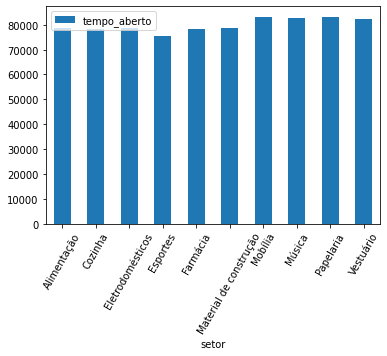

In [9]:
ax = max_setor.plot.bar(x='setor', y='tempo_aberto', rot=60)
plt.savefig('max_setor.png')

### O mínimo

Importante para checar erros de formatação da base de dados. Como vemos na análise, no caso do setor de **Vestuário**, é pouco provável que uma loja fique aberta por apenas 12 segundos, então provavelmente indica um erro no cadastro ou uma falaha na construção da pergunta que forma o banco de dados.

In [10]:
min_setor = empresa_setor.groupby(['setor']).min().reset_index()
min_setor['tempo_aberto'] = min_setor['tempo_aberto'].dt.seconds
min_setor

,setor,tempo_aberto
0,Alimentação,1337
1,Cozinha,642
2,Eletrodomésticos,647
3,Esportes,38
4,Farmácia,153
5,Material de construção,260
6,Mobília,37
7,Música,277
8,Papelaria,115
9,Vestuário,21


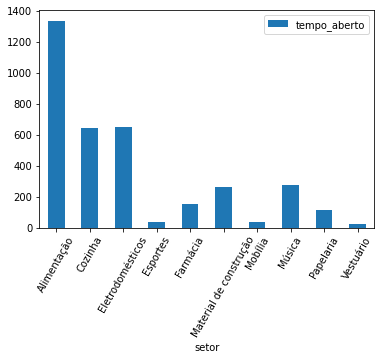

In [11]:
ax = min_setor.plot.bar(x='setor', y='tempo_aberto', rot=60)
plt.savefig('min_setor.png') 

### A média

Como era esperado, a média da quantidade de horas de funcionamento fica entre 7 e 8 horas. Podemos ainda afirmar que nesse caso os setores se comportam de forma quase análoga, não havendo significativa diferenciação de horas abertas entre eles

In [12]:
mean_setor = empresa_setor.groupby(['setor']).mean().reset_index()
mean_setor['tempo_aberto'] = mean_setor['tempo_aberto'].dt.seconds
mean_setor

,setor,tempo_aberto
0,Alimentação,29766
1,Cozinha,31121
2,Eletrodomésticos,27538
3,Esportes,26677
4,Farmácia,28311
5,Material de construção,29125
6,Mobília,30669
7,Música,30262
8,Papelaria,29135
9,Vestuário,30467


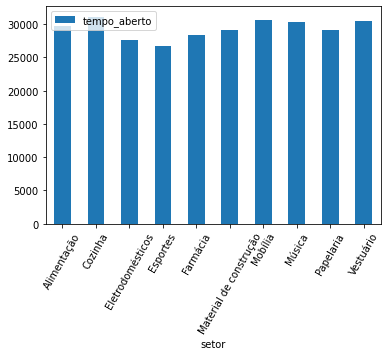

In [13]:
ax = mean_setor.plot.bar(x='setor', y='tempo_aberto', rot=60)
plt.savefig('mean_setor.png') 

## Pergunta 2: Qual a média, máximo e mínimo, por estado, do tempo que as empresas passam abertas?

### O máximo

Vemos uma tendência de dois estados de não ter lojas abertas por muito tempo. São eles DF e RO, ambos longe das regiões com maior PIB, quais sejam, Sudeste e Sul

In [14]:
max_estado = empresa_estado.groupby(['estado']).max().reset_index()
max_estado['tempo_aberto'] = max_estado['tempo_aberto'].dt.seconds
max_estado.head()

,estado,tempo_aberto
0,AC,67950
1,AL,81923
2,AM,73101
3,AP,62597
4,BA,79561


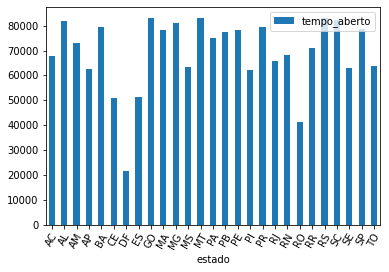

In [15]:
ax = max_estado.plot.bar(x='estado', y='tempo_aberto', rot=60)
plt.savefig('max_estado.png') 

### O mínimo

Importante para checar erros de formatação da base de dados. Assim como na análise em relação aos setores, provavelmente indica um erro no cadastro ou uma falaha na construção da pergunta que forma o banco de dados.

Os únicos estados que aparentemente não possuem esse erro são AP e RR, ambos na região norte do país.

In [16]:
min_estado = empresa_estado.groupby(['estado']).min().reset_index()
min_estado['tempo_aberto'] = min_estado['tempo_aberto'].dt.seconds
min_estado.head()

,estado,tempo_aberto
0,AC,15663
1,AL,3711
2,AM,120
3,AP,62597
4,BA,115


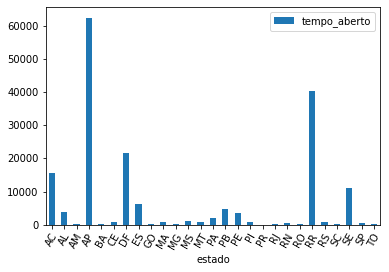

In [17]:
ax = min_estado.plot.bar(x='estado', y='tempo_aberto', rot=60)
plt.savefig('min_estado.png')

### A média

Diferentemente da análise por setores, a média encontrada varia entre os estados. Destacam-se novamente AP e RR como estados que possuem média grande de horas que empresas ficam abertas. A queda na média dos outros estados pode ser consequência das entradas erradas, como visto na análise do mínimo tempo aberto.

In [18]:
mean_estado = empresa_estado.groupby(['estado']).mean().reset_index()
mean_estado['tempo_aberto'] = mean_estado['tempo_aberto'].dt.seconds
mean_estado.head()

,estado,tempo_aberto
0,AC,38122
1,AL,35324
2,AM,24148
3,AP,62597
4,BA,26717


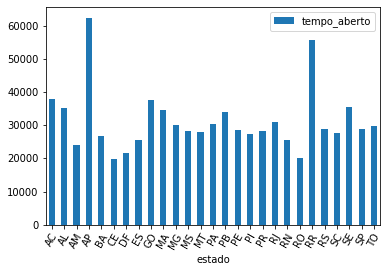

In [19]:
ax = mean_estado.plot.bar(x='estado', y='tempo_aberto', rot=60)
plt.savefig('mean_estado.png') 